<div align="center">

# Instituto Tecnológico y de Estudios Superiores de Monterrey

**Septiembre–Diciembre 2025**
**Maestría en Inteligencia Artificial Aplicada**

## Avance 4

**Modelos alternativos**

---

### Equipo académico

|                  | **Nombre**                            |
| ---------------- | ------------------------------------- |
| Profesor Titular | Dra. Grettel Barceló Alonso           |
| Asesora          | Dra. Ludivina Facundo Flores          |
| Tutor            | Mtra. Verónica Sandra Guzmán de Valle |
| Sponsor          | Dr. Jesús Arturo Pérez Díaz           |

---

### Proyecto Integrador

**TC5035.10**

---

### Integrantes

| **Nombre**                        | **Matrícula** |
| --------------------------------- | ------------- |
| Christopher Adolfo Orduña De León | A01795372     |
| Miguel Ángel Paredes Gutiérrez    | A01794138     |
| Carlos Mariano Ramírez Amaya      | A01795036     |

**Fecha:** 19 de Octubre del 2025

</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from tqdm import tqdm
from datetime import datetime, timezone

from sklearn.cluster import MiniBatchKMeans, KMeans

from sentence_transformers import SentenceTransformer

PATH = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\data\processed\Filtrado_Mayo_28_2025_output.parquet'

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))
display(df.head(5))

c:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\.venv\bgp_hijacking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape:  (316313, 19)
Columnas: ['time', 'collector', 'peer_asn', 'peer_ip', 'type', 'prefix', 'next_hop', 'as_path', 'origin', 'as_path_length', 'secs_between_announcements', 'unique_as_in_path', 'as_path_length_diff_A', 'as_path_length_diff_A_abs', 'origin_at_time_nuniq', 'MOAS', 'as_path_embedding', 'prev_embedding', 'cosine_distance_prev_A']


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


## Markov

In [2]:
df['prefix'].value_counts().sort_values(ascending=False)[:10].to_frame().reset_index()

,prefix,count
0,156.227.32.0/21,1974
1,103.199.103.0/24,727
2,103.86.46.0/24,705
3,103.86.47.0/24,702
4,103.86.44.0/24,701
5,103.86.45.0/24,701
6,116.204.170.0/24,681
7,116.204.169.0/24,679
8,116.204.171.0/24,677
9,137.59.18.0/24,655


In [3]:
prefix = '156.227.32.0/21'

prefix_df = df[df['prefix']==prefix]
display(prefix_df.head(3))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987


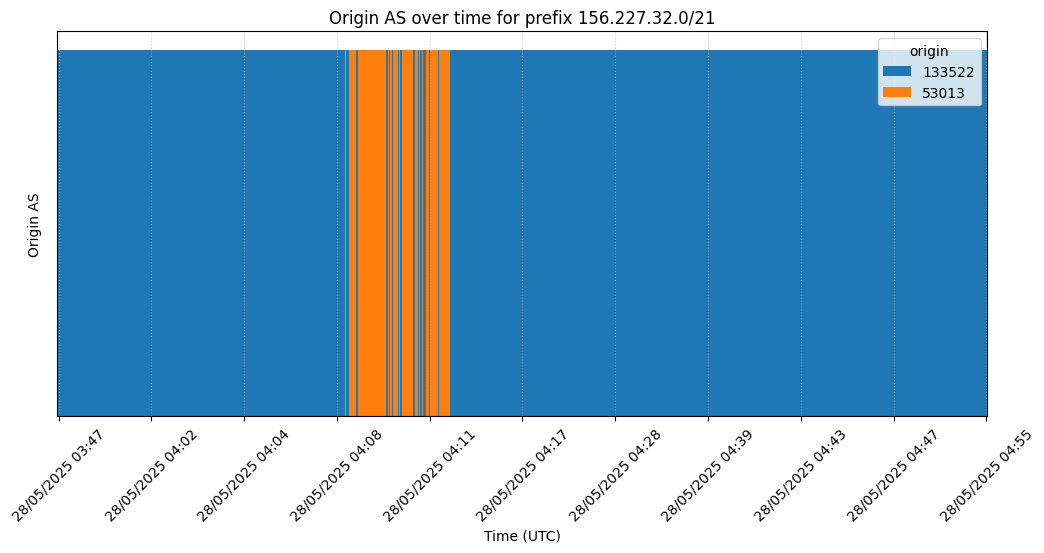

In [4]:
df_copy = df.copy()
df_copy['formatted_time'] = pd.to_datetime(df_copy['time'], unit='s', utc=True, errors='coerce')

target_prefix = prefix

df_target = df_copy[(df_copy['prefix'] == target_prefix) & (df_copy['type'] == 'A')].sort_values('formatted_time')

freq = '1s'

df_target = df_target.set_index('formatted_time').resample(freq)['origin'].last().dropna().reset_index()

df_counts = df_target.groupby([pd.Grouper(key='formatted_time', freq=freq), 'origin']).size().unstack(fill_value=0)

ax = df_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12,5),
    # Colormap='tab10',
    width=1.0
)

plt.title(f'Origin AS over time for prefix {target_prefix}', fontsize=12)
plt.xlabel('Time (UTC)')
plt.ylabel('Origin AS')
ax.set(yticklabels=[])
ax.tick_params(left=False)
plt.xticks(ticks=range(0, len(df_counts), max(1, len(df_counts)//10)),
           labels=[d.strftime('%d/%m/%Y %H:%M') for d in df_counts.index[::max(1, len(df_counts)//10)]],
           rotation=45)
plt.grid(True, axis='x', linestyle=':', alpha=0.6)

plt.show()

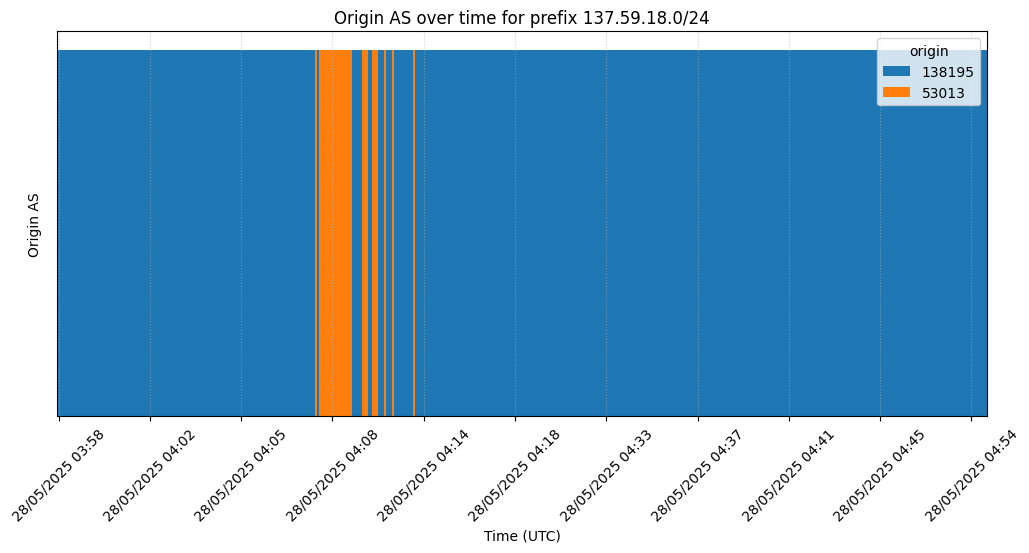

In [5]:
df_copy = df.copy()
df_copy['formatted_time'] = pd.to_datetime(df_copy['time'], unit='s', utc=True, errors='coerce')

target_prefix = prefix

df_target = df_copy[(df_copy['prefix'] == target_prefix) & (df_copy['type'] == 'A')].sort_values('formatted_time')

freq = '1s'

df_target = df_target.set_index('formatted_time').resample(freq)['origin'].last().dropna().reset_index()

df_counts = df_target.groupby([pd.Grouper(key='formatted_time', freq=freq), 'origin']).size().unstack(fill_value=0)

ax = df_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12,5),
    # Colormap='tab10',
    width=1.0
)

plt.title(f'Origin AS over time for prefix {target_prefix}', fontsize=12)
plt.xlabel('Time (UTC)')
plt.ylabel('Origin AS')
ax.set(yticklabels=[])
ax.tick_params(left=False)
plt.xticks(ticks=range(0, len(df_counts), max(1, len(df_counts)//10)),
           labels=[d.strftime('%d/%m/%Y %H:%M') for d in df_counts.index[::max(1, len(df_counts)//10)]],
           rotation=45)
plt.grid(True, axis='x', linestyle=':', alpha=0.6)

plt.show()

### Generar estados

Embeddings `AS_PATH` + `PREFIX`

In [5]:
def filter_by_utc_window(df, start_str, end_str):
    # Parseo como UTC
    start = datetime.strptime(start_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)
    end   = datetime.strptime(end_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)

    # A epoch seconds (enteros)
    start_s = int(start.timestamp())
    end_s   = int(end.timestamp())

    # Inicio inclusivo, fin exclusivo (ajusta según necesites)
    mask = (df["time"] >= start_s) & (df["time"] < end_s)
    return df.loc[mask].copy()

df_event = filter_by_utc_window(df=prefix_df,
                                start_str='2025-05-28 03:37', # Periodo antes
                                end_str='2025-05-28 04:07') # del evento de secuestro
display(df_event)

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,0.494050,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,6.314879,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418647,1.748405e+09,route-views.ny,209823,206.82.105.109,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418648,1.748405e+09,route-views.eqix,6057,206.126.236.189,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418649,1.748405e+09,route-views.eqix,11039,206.126.236.172,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418650,1.748405e+09,route-views.ny,398465,206.82.104.185,A,156.227.32.0/21,206.82.104.185,398465 7029 6461 3491 150684 138195 133522,133522,7,11.203748,7,0.0,0.0,1,0,"[-0.010729912, -0.04826849, -0.09244486, -0.01...","[-0.016531646, -0.07118929, -0.08040959, -0.02...",0.106572


In [6]:
EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

In [7]:
# Filtramos filas válidas
mask_valid = (
    df_event['prefix'].notna()
)

# Combinamos prefix + as_path
df_event['state_embedding'] = df_event['type'].astype(str) + " " + df_event['prefix'].astype(str) + " " + df_event['origin'].astype(str) + " " + df_event['as_path'].astype(str)

# Generamos embeddings solo para filas válidas
valid_texts = df_event.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

Batches: 100%|██████████| 17/17 [00:00<00:00, 48.02it/s]


In [8]:
for i, idx in enumerate(df_event.index[mask_valid]):
  df_event.at[idx, 'state_embedding'] = embeddings[i]

display(df_event.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A,state_embedding
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN,"[-0.0041357153, 0.013522448, -0.098932154, 0.0..."
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257,"[-0.0039059862, 0.009959294, -0.08870342, 0.01..."
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987,"[-0.009323231, 0.015897159, -0.069182985, 0.00..."
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,0.494050,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318,"[0.0007613517, 0.0076228185, -0.09350564, 0.01..."
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,6.314879,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136,"[-0.014641215, 0.01910438, -0.09241671, 0.0033..."


#### Discretización de los embeddigs

In [9]:
# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_event['state_embedding'].values)
print("Shape:", X.shape)

Shape: (542, 384)


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


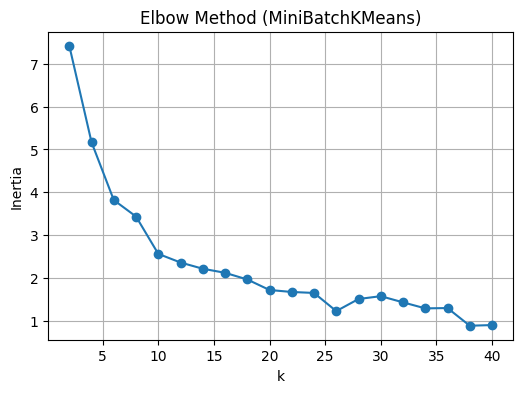

In [10]:
k_values = range(2, 41, 2)
inertias = []

for k in tqdm(k_values):
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=64, random_state=42)
    labels = mbk.fit_predict(X)
    inertias.append(mbk.inertia_)

# Graficar Elbow
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (MiniBatchKMeans)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [11]:
n_clusters = 10

mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, random_state=42)
df_event.loc[:,'state_id'] = mbk.fit_predict(X)

display(df_event)

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,...,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A,state_embedding,state_id
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,...,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",9
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,...,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",9
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,...,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",8
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,...,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318,"[0.0007613517, 0.0076228185, -0.09350564, 0.01...",1
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,...,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418647,1.748405e+09,route-views.ny,209823,206.82.105.109,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418648,1.748405e+09,route-views.eqix,6057,206.126.236.189,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418649,1.748405e+09,route-views.eqix,11039,206.126.236.172,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418650,1.748405e+09,route-views.ny,398465,206.82.104.185,A,156.227.32.0/21,206.82.104.185,398465 7029 6461 3491 150684 138195 133522,133522,7,...,7,0.0,0.0,1,0,"[-0.010729912, -0.04826849, -0.09244486, -0.01...","[-0.016531646, -0.07118929, -0.08040959, -0.02...",0.106572,"[-0.0071761897, 0.016782993, -0.09739853, 0.01...",1


In [ ]:
import joblib

joblib.dump(mbk, r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_137_59_18_0_24_k_18.pkl')

In [12]:
df_train = df_event[['time','prefix','origin','as_path','state_embedding','state_id']].reset_index(drop=True)
display(df_train)

,time,prefix,origin,as_path,state_embedding,state_id
0,1.748404e+09,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",9
1,1.748404e+09,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",9
2,1.748405e+09,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",8
3,1.748405e+09,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.0007613517, 0.0076228185, -0.09350564, 0.01...",1
4,1.748405e+09,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",9
...,...,...,...,...,...,...
537,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
538,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
539,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
540,1.748405e+09,156.227.32.0/21,133522,398465 7029 6461 3491 150684 138195 133522,"[-0.0071761897, 0.016782993, -0.09739853, 0.01...",1


### Generación del modelo

In [13]:
df_train['next_state_id'] = df_train['state_id'].shift(-1)

df_transitions = df_train.dropna(subset=['next_state_id']).copy()

df_transitions['next_state_id'] = df_transitions['next_state_id'].astype(int)

# Contar frecuencia de cada transición
transition_counts = (
    df_transitions.groupby(["state_id", "next_state_id"])
    .size()
    .unstack(fill_value=0)
)

# Normalizar por fila → P(j | i) Matrix de probabilidad de transición entre estados
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

transition_matrix

next_state_id,0,1,2,3,4,5,6,7,8,9
state_id,,,,,,,,,,
0,0.417323,0.283465,0.031496,0.023622,0.094488,0.047244,0.023622,0.015748,0.023622,0.039370
1,0.362637,0.164835,0.021978,0.054945,0.054945,0.109890,0.076923,0.032967,0.021978,0.098901
2,0.176471,0.058824,0.117647,0.000000,0.058824,0.058824,0.058824,0.176471,0.000000,0.294118
3,0.333333,0.166667,0.000000,0.055556,0.166667,0.000000,0.055556,0.000000,0.055556,0.166667
4,0.083333,0.116667,0.050000,0.016667,0.133333,0.100000,0.233333,0.066667,0.000000,0.200000
5,0.105263,0.157895,0.000000,0.035088,0.140351,0.122807,0.157895,0.000000,0.035088,0.245614
6,0.140625,0.062500,0.046875,0.031250,0.140625,0.156250,0.218750,0.046875,0.031250,0.125000
7,0.111111,0.037037,0.074074,0.000000,0.148148,0.185185,0.037037,0.296296,0.037037,0.074074
8,0.230769,0.307692,0.000000,0.000000,0.153846,0.000000,0.230769,0.000000,0.000000,0.076923


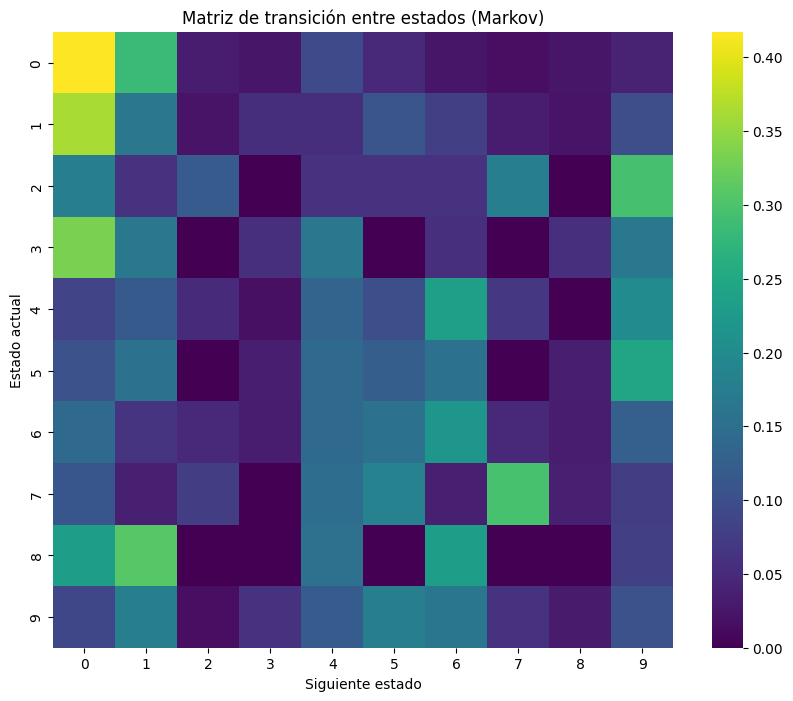

In [14]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, cmap="viridis", cbar=True)
plt.title("Matriz de transición entre estados (Markov)")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.show()

In [ ]:
joblib.dump(transition_matrix, r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_prefix_137_59_18_0_24_k_18.pkl')

## Inferencia

In [1]:
import numpy as np
import pandas as pd

import joblib
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'

DATA_PATH = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\data\processed\Filtrado_Mayo_28_2025_output.parquet'

df = pd.read_parquet(DATA_PATH, engine="pyarrow")
display(df.head(5))

c:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\.venv\bgp_hijacking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [2]:
def generate_state_embeddings(df: pd.DataFrame, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2') -> pd.DataFrame:
    """
    Genera embeddings (vectores numéricos) a partir de las columnas 'prefix' y 'as_path'
    y los almacena en una nueva columna llamada 'state_embedding'.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada con al menos las columnas 'prefix' y 'as_path'.
    model_name : str, opcional
        Nombre del modelo SentenceTransformer a usar (por defecto: MiniLM-L6-v2).
    
    Retorna
    -------
    pd.DataFrame
        Copia del DataFrame original con la columna 'state_embedding' añadida.
    """

    # Hacemos una copia para no modificar el DataFrame original
    df_out = df.copy()

    # Cargamos el modelo de embeddings
    model = SentenceTransformer(model_name)

    # Filtramos filas válidas (sin valores nulos o vacíos en prefix/as_path)
    mask_valid = (
        df_out['prefix'].notna()
    )

    # Combinamos prefix + as_path en un solo texto (input para el modelo)
    df_out['state_text'] = df_out['type'].astype(str) + " " + df_out['prefix'].astype(str) + " " + df_out['origin'].astype(str) + " " + df_out['as_path'].astype(str)

    # Obtenemos los textos válidos a procesar
    valid_texts = df_out.loc[mask_valid, 'state_text'].tolist()

    # Generamos los embeddings (vectores de alta dimensión)
    embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

    # Inicializamos la nueva columna
    df_out['state_embedding'] = None

    # Asignamos los embeddings solo a las filas válidas
    for i, idx in enumerate(df_out.index[mask_valid]):
        df_out.at[idx, 'state_embedding'] = embeddings[i]

    # Eliminamos la columna temporal 'state_text'
    df_out.drop(columns=['state_text'], inplace=True)
    df_out['state_embedding'].dropna(inplace=True)

    return df_out


### Prefijo 156.227.32.0/21

In [3]:
MBK_156_227_32_0_21 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_156_227_32_0_21_k_10.pkl'
TRANSITION_MATRIX_156_227_32_0_21 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_hijack_prefix_156_227_32_0_21_k_10.pkl'

PREFIX = '156.227.32.0/21'

mbk = joblib.load(MBK_156_227_32_0_21)
transition_matrix = joblib.load(TRANSITION_MATRIX_156_227_32_0_21)

df_inference = df[df['prefix']==PREFIX][['time','collector','type','prefix','origin','as_path']]
display(df.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [4]:
df_inference_embed = generate_state_embeddings(df_inference, EMBEDDINGS_MODEL)
display(df_inference_embed.head(5))

Batches: 100%|██████████| 62/62 [00:00<00:00, 77.50it/s]


,time,collector,type,prefix,origin,as_path,state_embedding
1418110,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0..."
1418111,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01..."
1418112,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00..."
1418113,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.00076137634, 0.007622741, -0.093505695, 0.0..."
1418114,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033..."


#### Generación de los estados a partir del entrenamiento

In [5]:
X = np.vstack(df_inference_embed['state_embedding'].values)
print("Shape:", X.shape)

df_inference_embed.loc[:,'state_id'] = mbk.predict(X)
display(df_inference_embed.head(5))

Shape: (1974, 384)


,time,collector,type,prefix,origin,as_path,state_embedding,state_id
1418110,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",0
1418111,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",0
1418112,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",5
1418113,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.00076137634, 0.007622741, -0.093505695, 0.0...",4
1418114,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",0


#### Obtener probabilidades

In [6]:
df_inferences = (
    df_inference_embed[["time", "state_id"]]
    .reset_index(drop=True)
)

# Siguiente estado (shift -1)
df_inferences["next_state_id"] = df_inferences["state_id"].shift(-1).fillna(-1).astype(int)
display(df_inferences.head(5))

,time,state_id,next_state_id
0,1.748404e+09,0,0
1,1.748404e+09,0,5
2,1.748405e+09,5,4
3,1.748405e+09,4,0
4,1.748405e+09,0,5


In [7]:
# Serie con las probabilidades P(j|i) de la matriz de transición
#    (MultiIndex: (state_i, state_j) -> prob)
probs_series = transition_matrix.stack()
probs_series

state_id  next_state_id
0         0                0.239130
          1                0.086957
          2                0.043478
          3                0.032609
          4                0.304348
                             ...   
9         5                0.037037
          6                0.185185
          7                0.000000
          8                0.000000
          9                0.296296
Length: 100, dtype: float64

In [8]:
# 4) Construimos las llaves (i, j) para cada fila y mapeamos en vector
keys = pd.MultiIndex.from_arrays(
    [df_inferences["state_id"], df_inferences["next_state_id"]]
)

df_inferences["trans_prob"] = probs_series.reindex(keys).to_numpy()

# 5) Limpieza:
#    - La última fila no tiene next_state_id -> NaN
#    - Transiciones nunca vistas -> NaN -> 0.0
df_inferences["trans_prob"] = df_inferences["trans_prob"].fillna(0.0)

display(df_inferences)

,time,state_id,next_state_id,trans_prob
0,1.748404e+09,0,0,0.239130
1,1.748404e+09,0,5,0.021739
2,1.748405e+09,5,4,0.461538
3,1.748405e+09,4,0,0.149425
4,1.748405e+09,0,5,0.021739
...,...,...,...,...
1969,1.748408e+09,8,0,0.083333
1970,1.748408e+09,0,8,0.054348
1971,1.748408e+09,8,8,0.083333
1972,1.748408e+09,8,8,0.083333


Negative Log-Likelihood (NLL)

$ NLL=−t∑​logP(st+1​∣st​) $

In [ ]:
# Score de anomalía: NLL por transición
eps = 1e-12 # Evita el log(0)
df_inferences["nll"] = -np.log(df_inferences["trans_prob"].clip(lower=eps)) # -log(P(st+1|st))

display(df_inferences)

,time,state_id,next_state_id,trans_prob,nll
0,1.748404e+09,0,0,0.239130,1.430746
1,1.748404e+09,0,5,0.021739,3.828641
2,1.748405e+09,5,4,0.461538,0.773190
3,1.748405e+09,4,0,0.149425,1.900959
4,1.748405e+09,0,5,0.021739,3.828641
...,...,...,...,...,...
1969,1.748408e+09,8,0,0.083333,2.484907
1970,1.748408e+09,0,8,0.054348,2.912351
1971,1.748408e+09,8,8,0.083333,2.484907
1972,1.748408e+09,8,8,0.083333,2.484907


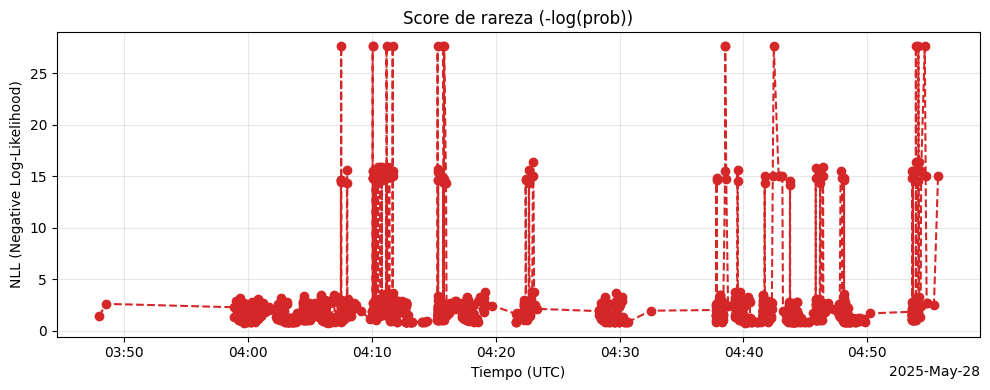

In [10]:
window = 2

df_inferences['nll_smooth'] = df_inferences['nll'].rolling(window=window, min_periods=1).mean()

df_inferences['time_dt'] = pd.to_datetime(df_inferences['time'], unit='s', utc=True)

df_inferences = df_inferences.sort_values('time_dt')

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)

# Grafica nll en su propio plot
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(df_inferences['time_dt'], df_inferences['nll_smooth'], color='tab:red', linestyle='--', marker='o')
ax2.set_title("Score de rareza (-log(prob))")
ax2.set_xlabel("Tiempo (UTC)")
ax2.set_ylabel("NLL (Negative Log-Likelihood)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

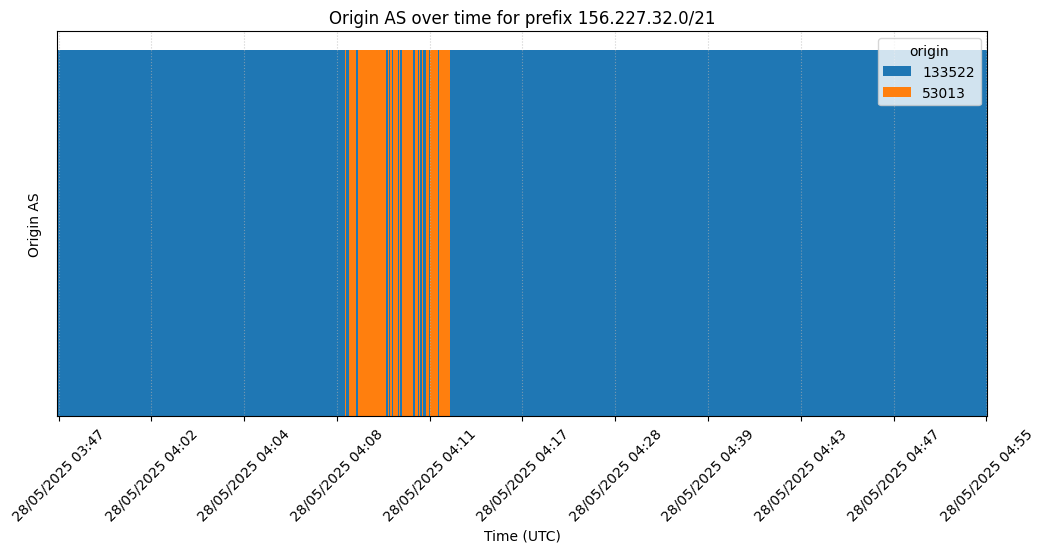

### Prefijo 137.59.18.0/24

In [11]:
MBK_137_59_18_0_24 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_137_59_18_0_24_k_18.pkl'
TRANSITION_MATRIX_137_59_18_0_24 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_prefix_137_59_18_0_24_k_18.pkl'

PREFIX = '137.59.18.0/24'

mbk = joblib.load(MBK_137_59_18_0_24)
transition_matrix = joblib.load(TRANSITION_MATRIX_137_59_18_0_24)

df_inference = df[df['prefix']==PREFIX][['time','collector','type','prefix','origin','as_path']]
display(df.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [12]:
df_inference_embed = generate_state_embeddings(df_inference, EMBEDDINGS_MODEL)
display(df_inference_embed.head(5))

Batches: 100%|██████████| 21/21 [00:00<00:00, 62.45it/s]


,time,collector,type,prefix,origin,as_path,state_embedding
719975,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,16552 2914 3786 138195 138195,"[-0.07483852, 0.059032775, -0.023612479, 0.028..."
719976,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,11039 4901 11164 3786 138195 138195,"[-0.07715189, 0.07551787, -0.03519158, 0.02309..."
719977,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6830 174 3786 138195 138195,"[-0.05049928, 0.06606932, -0.03694837, 0.03835..."
719978,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6939 3786 138195 138195,"[-0.059439927, 0.0695423, -0.030375622, 0.0366..."
719979,1.748405e+09,route-views.ny,A,137.59.18.0/24,138195,49544 3786 138195 138195,"[-0.052429806, 0.052830707, -0.028444333, 0.03..."


In [13]:
X = np.vstack(df_inference_embed['state_embedding'].values)
print("Shape:", X.shape)

df_inference_embed.loc[:,'state_id'] = mbk.predict(X)
display(df_inference_embed.head(5))

Shape: (655, 384)


,time,collector,type,prefix,origin,as_path,state_embedding,state_id
719975,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,16552 2914 3786 138195 138195,"[-0.07483852, 0.059032775, -0.023612479, 0.028...",6
719976,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,11039 4901 11164 3786 138195 138195,"[-0.07715189, 0.07551787, -0.03519158, 0.02309...",7
719977,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6830 174 3786 138195 138195,"[-0.05049928, 0.06606932, -0.03694837, 0.03835...",12
719978,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6939 3786 138195 138195,"[-0.059439927, 0.0695423, -0.030375622, 0.0366...",14
719979,1.748405e+09,route-views.ny,A,137.59.18.0/24,138195,49544 3786 138195 138195,"[-0.052429806, 0.052830707, -0.028444333, 0.03...",7


In [14]:
df_inferences = (
    df_inference_embed[["time", "state_id"]]
    .reset_index(drop=True)
)

# Siguiente estado (shift -1)
df_inferences["next_state_id"] = df_inferences["state_id"].shift(-1).fillna(-1).astype(int)
display(df_inferences.head(5))

,time,state_id,next_state_id
0,1.748405e+09,6,7
1,1.748405e+09,7,12
2,1.748405e+09,12,14
3,1.748405e+09,14,7
4,1.748405e+09,7,15


In [15]:
# Serie con las probabilidades P(j|i) de la matriz de transición
#    (MultiIndex: (state_i, state_j) -> prob)
probs_series = transition_matrix.stack()
probs_series

state_id  next_state_id
0         0                0.210526
          1                0.000000
          2                0.210526
          3                0.000000
          4                0.000000
                             ...   
17        13               0.000000
          14               0.000000
          15               0.000000
          16               0.000000
          17               0.000000
Length: 324, dtype: float64

In [16]:
# Construimos las llaves (i, j) para cada fila y mapeamos en vector
keys = pd.MultiIndex.from_arrays(
    [df_inferences["state_id"], df_inferences["next_state_id"]]
)

df_inferences["trans_prob"] = probs_series.reindex(keys).to_numpy()

# Limpieza:
#    - La última fila no tiene next_state_id -> NaN
#    - Transiciones nunca vistas -> NaN -> 0.0
df_inferences["trans_prob"] = df_inferences["trans_prob"].fillna(0.0)

display(df_inferences)

,time,state_id,next_state_id,trans_prob
0,1.748405e+09,6,7,0.200000
1,1.748405e+09,7,12,0.125000
2,1.748405e+09,12,14,0.166667
3,1.748405e+09,14,7,0.333333
4,1.748405e+09,7,15,0.062500
...,...,...,...,...
650,1.748408e+09,10,13,0.142857
651,1.748408e+09,13,10,0.000000
652,1.748408e+09,10,2,0.285714
653,1.748408e+09,2,2,0.142857


In [17]:
# Score de anomalía: NLL por transición
eps = 1e-12 # Evita el log(0)
df_inferences["nll"] = -np.log(df_inferences["trans_prob"].clip(lower=eps))

display(df_inferences)

,time,state_id,next_state_id,trans_prob,nll
0,1.748405e+09,6,7,0.200000,1.609438
1,1.748405e+09,7,12,0.125000,2.079442
2,1.748405e+09,12,14,0.166667,1.791759
3,1.748405e+09,14,7,0.333333,1.098612
4,1.748405e+09,7,15,0.062500,2.772589
...,...,...,...,...,...
650,1.748408e+09,10,13,0.142857,1.945910
651,1.748408e+09,13,10,0.000000,27.631021
652,1.748408e+09,10,2,0.285714,1.252763
653,1.748408e+09,2,2,0.142857,1.945910


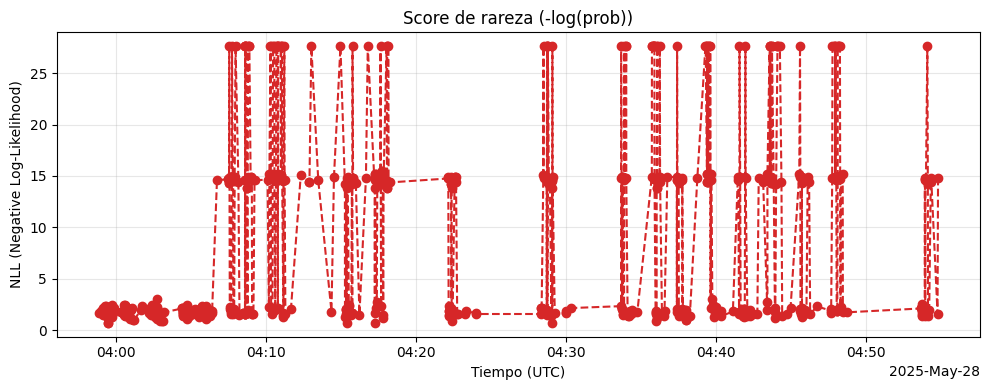

In [18]:
window = 2

df_inferences['nll_smooth'] = df_inferences['nll'].rolling(window=window, min_periods=1).mean()

df_inferences['time_dt'] = pd.to_datetime(df_inferences['time'], unit='s', utc=True)

df_inferences = df_inferences.sort_values('time_dt')

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)

# Grafica nll en su propio plot
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(df_inferences['time_dt'], df_inferences['nll_smooth'], color='tab:red', linestyle='--', marker='o')
ax2.set_title("Score de rareza (-log(prob))")
ax2.set_xlabel("Tiempo (UTC)")
ax2.set_ylabel("NLL (Negative Log-Likelihood)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

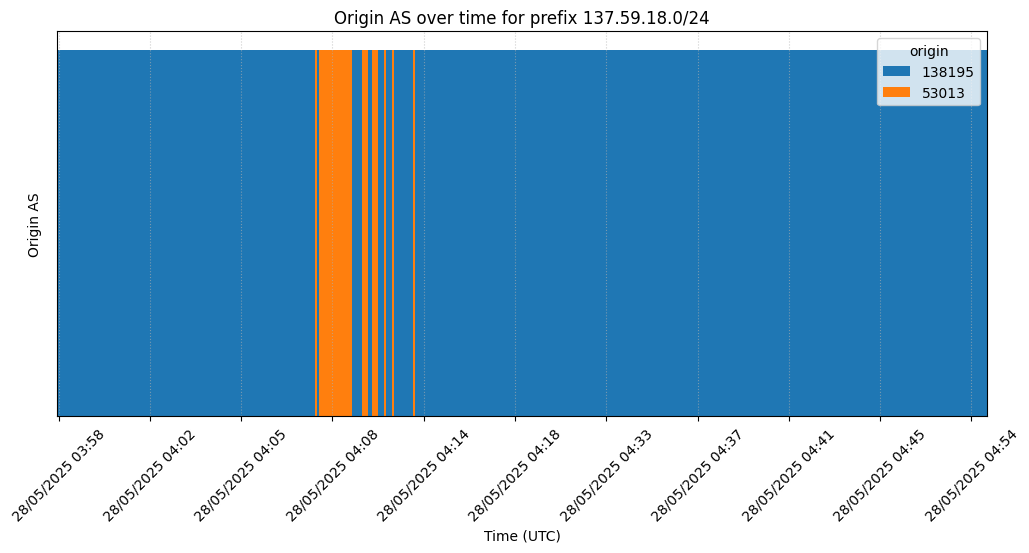